# Convolutional Neural Network

A specific kind of such a deep neural network is the convolutional network, which is commonly referred to as CNN or ConvNet. It's a deep, feed-forward artificial neural network. Remember that feed-forward neural networks are also called multi-layer perceptrons(MLPs), which are the quintessential deep learning models. The models are called "feed-forward" because information flows right through the model. There are no feedback connections in which outputs of the model are fed back into itself.

These neural networks have proven to be successful in many different real-life case studies and applications, like:
 * Image classification, object detection, segmentation, face recognition;
 * Self driving cars that leverage CNN based vision systems;
 * Classification of crystal structure using a convolutional neural network;
 
You feed an image as an input to the network, which goes through multiple convolutions, subsampling, a fully connected layer and finally outputs something. 

![Alt](./Typical_cnn_kecdep.png "CNN")

But what are all these concepts?

1. The convolution layer computes the output of neurons that are connected to local regions or receptive fields in the input, each computing a dot product between their weights and a small receptive field to which they are connected to in the input volume. Each computation leads to extraction of a feature map from the input image. In other words, imagine you have an image represented as a 5x5 matrix of values, and you take a 3x3 matrix and slide that 3x3 window or kernel around the image. At each position of that matrix, you multiply the values of your 3x3 window by the values in the image that are currently being covered by the window. As a result, you'll get a single number that represents all the values in that window of the images. You use this layer to filtering: as the window moves over the image, you check for patterns in that section of the image. This works because of filters, which are multiplied by the values outputted by the convolution.

2. The objective of subsampling is to get an input representation by reducing its dimensions, which helps in reducing overfitting. One of the techniques of subsampling is max pooling. With this technique, you select the highest pixel value from a region depending on its size. In other words, max pooling takes the largest value from the window of the image currently covered by the kernel. For example, you can have a max-pooling layer of size 2 x 2 will select the maximum pixel intensity value from 2 x 2 region. You're right to think that the pooling layer then works a lot like the convolution layer! You also take a kernel or a window and move it over the image; The only difference is the function that is applied to the kernel and the image window isn't linear.

3. The objective of the fully connected layer is to flatten the high-level features that are learned by convolutional layers and combining all the features. It passes the flattened output to the output layer where you use a softmax classifier or a sigmoid to predict the input class label.

### Data Analysis

In [1]:
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

Using TensorFlow backend.


In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [3]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


The Classes correspond to the different labes that each figure represents (i.e. all boots would be label as 9)

Take a look at the dataset images.

Text(0.5, 1, 'Ground Truth : 9')

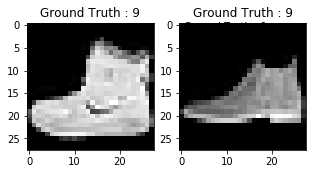

In [4]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))
plt.text(0.5,1,u'Ground Truth : 9')

## Data Preprocessing

Convert each 28 x 28 image of the train and test set into a matrix of size 28 x 28 x 1 which is fed into the network.

In [5]:
train_X = train_X.reshape(-1, 28,28, 1)
test_X = test_X.reshape(-1, 28,28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

The data right now is in an int8 format, so before you feed it into the network you need to convert its type to float32, and you also have to rescale the pixel values in range 0 - 1 inclusive. So let's do that!

In [6]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

Now you need to convert the class labels into a one-hot encoding vector. In one-hot encoding, you convert the categorical data into a vector of numbers. The reason why you convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

In [7]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 9
After conversion to one-hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


__This last step is a crucial one. In machine learning or any data specific task, you should partition the data correctly. For the model to generalize well, you split the training data into two parts, one designed for training and another one for validation. In this case, you will train the model on 80\% of the training data and validate it on 20\% of the remaining training data. This will also help to reduce overfitting since you will be validating the model on the data it would not have seen in training phase, which will help in boosting the test performance.__

In [8]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

### Model the Data

Import all the necessary modules required to train the model.

In [9]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

We use a batch size of 64. Using a higher batch size of 128 or 256 is also preferable, it all depends on the memory. We train the network for 20 epochs.

In [10]:
batch_size = 64
epochs = 20
num_classes = 10

### Neural Network Architecture

In Keras, you can just stack up layers by adding the desired layer one by one. That's exactly what you'll do here: you'll first add a first convolutional layer with Conv2D(). Note that you use this function because you're working with images! Next, you add the Leaky ReLU activation function which helps the network learn non-linear decision boundaries.

_The ReLU activation function is used a lot in neural network architectures and more specifically in convolutional networks, where it has proven to be more effective than the widely used logistic sigmoid function. The ReLU function allows the activation to be thresholded at zero. However, during the training, ReLU units can "die". This can happen when a large gradient flows through a ReLU neuron: it can cause the weights to update in such a way that the neuron will never activate on any data point again. If this happens, then the gradient flowing through the unit will forever be zero from that point on. Leaky ReLUs attempt to solve this: the function will not be zero but will instead have a small negative slope._

In [11]:
fashion_model = Sequential()
fashion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D((2, 2),padding='same'))
fashion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
fashion_model.add(Flatten())
fashion_model.add(Dense(128, activation='linear'))
fashion_model.add(LeakyReLU(alpha=0.1))                  
fashion_model.add(Dense(num_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


### Compile the Model

The model is compiled using the Adam optimizer. Additionally, we specify the loss type which is categorical cross entropy which is used for multi-class classification, you can also use binary cross-entropy as the loss function. Lastly, you specify the metrics as accuracy which you want to analyze while the model is training.

In [12]:
fashion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

The layers above can be summarized in order to show some parameters (weights and biases) in each layer and also the total parameters in your model.

In [13]:
fashion_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         73856     
__________

### Train the Model

It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. The fit() function will return a history object; By storying the result of this function in fashion_train, you can use it later to plot the accuracy and loss function plots between training and validation which will help you to analyze your model's performance visually.

In [14]:
fashion_train = fashion_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.4542 - acc: 0.8355 - val_loss: 0.3659 - val_acc: 0.8633
Epoch 2/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.2866 - acc: 0.8940 - val_loss: 0.3074 - val_acc: 0.8864
Epoch 3/20
48000/48000 [==============================] - 50s 1ms/step - loss: 0.2371 - acc: 0.9128 - val_loss: 0.2369 - val_acc: 0.9120
Epoch 4/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.2037 - acc: 0.9249 - val_loss: 0.2261 - val_acc: 0.9167
Epoch 5/20
48000/48000 [==============================] - 49s 1ms/step - loss: 0.1828 - acc: 0.9331 - val_loss: 0.2220 - val_acc: 0.9196
Epoch 6/20
48000/48000 [==============================] - 51s 1ms/step - loss: 0.1602 - acc: 0.9401 - val_loss: 0.2371 - val_acc: 0.9144
Epoch 7/20
48000/48000 [==============================] - 50s 1ms/step - loss: 0

By observing the training accuracy and loss, you can say that the model did a good job since after 20 epochs the training accuracy is 99% and the training loss is quite low.

However, it looks like the model is overfitting, as the validation loss is 0.4396 and the validation accuracy is 92%. __Overfitting gives an intuition that the network has memorized the training data very well but is not guaranteed to work on unseen data, and that is why there is a difference in the training and validation accuracy.__

Let's evaluate the performance of your model on the test set before you come on to a conclusion.

In [15]:
test_eval = fashion_model.evaluate(test_X, test_Y_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.4959687774956226
Test accuracy: 0.9145


Let's plot the accuracy and loss plots between training and validation data.

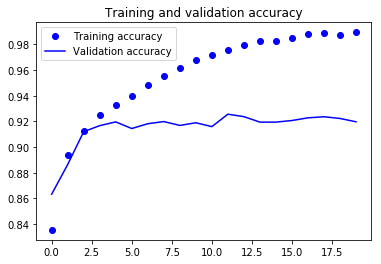

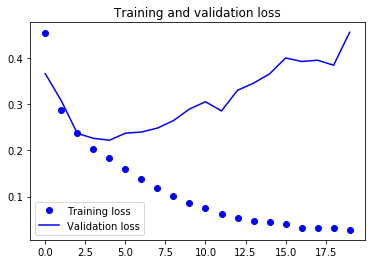

In [16]:
accuracy = fashion_train.history['acc']
val_accuracy = fashion_train.history['val_acc']
loss = fashion_train.history['loss']
val_loss = fashion_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()